In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
# The raw file URL from your GitHub repository
file_url = 'https://github.com/shoonil/rgbextractionUAV_Sentinel2/raw/main/Sentinel%20UAV%20RGB%20Data%20Nov%2025%202025.xlsx'

# Read the Excel file directly from the URL
df = pd.read_excel(file_url)

# Data Exploration

## Data Exploration: UAV vs S2

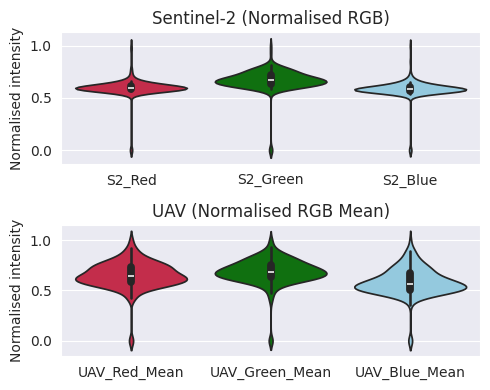

In [ ]:
# --- Normalise Sentinel-2 bands ---
scaler_s2 = MinMaxScaler()
s2_norm = scaler_s2.fit_transform(df[['S2_Red', 'S2_Green', 'S2_Blue']])
s2_norm_df = pd.DataFrame(s2_norm, columns=['S2_Red', 'S2_Green', 'S2_Blue'])

# --- Normalise UAV mean bands ---
scaler_uav_mean = MinMaxScaler()
uav_norm_mean = scaler_uav_mean.fit_transform(
    df[['UAV_Red_Mean', 'UAV_Green_Mean', 'UAV_Blue_Mean']]
)
uav_norm_df_mean = pd.DataFrame(
    uav_norm_mean,
    columns=['UAV_Red_Mean', 'UAV_Green_Mean', 'UAV_Blue_Mean']
)

# --- Normalise UAV std bands ---
scaler_uav_std = MinMaxScaler()
uav_norm_std = scaler_uav_std.fit_transform(
    df[['UAV_Red_Std', 'UAV_Green_Std', 'UAV_Blue_Std']]
)
uav_norm_df_std = pd.DataFrame(
    uav_norm_std,
    columns=['UAV_Red_Std', 'UAV_Green_Std', 'UAV_Blue_Std']
)

# --- Plot violin plots ---
fig, axes = plt.subplots(2, 1, figsize=(5,4))

rgb_palette = ['crimson', 'green', 'skyblue']

# Sentinel-2 violin plot (normalised)
sns.violinplot(
    data=s2_norm_df,
    ax=axes[0],
    palette=rgb_palette
)
axes[0].set_ylabel('Normalised intensity')
axes[0].set_title("Sentinel-2 (Normalised RGB)")

# UAV violin plot (normalised mean)
sns.violinplot(
    data=uav_norm_df_mean,
    ax=axes[1],
    palette=rgb_palette
)
axes[1].set_ylabel('Normalised intensity')
axes[1].set_title("UAV (Normalised RGB Mean)")

plt.tight_layout()
plt.savefig('ViolinPlot.png', dpi=300)
plt.show()


**Data Distrubution: Summary**
The UAV-derived mean reflectance shows broader and more variable distributions than Sentinel-2. Each sub-10 cm pixel captures highly localised canopy features, such as sunlit leaves, shaded branches and small gaps. This produces a wider spread of normalised values, particularly in the blue channel. The broader distributions illustrate the much richer radiometric and spatial detail contained in UAV imagery, which is largely lost at satellite scale.

# Correlation Exploration

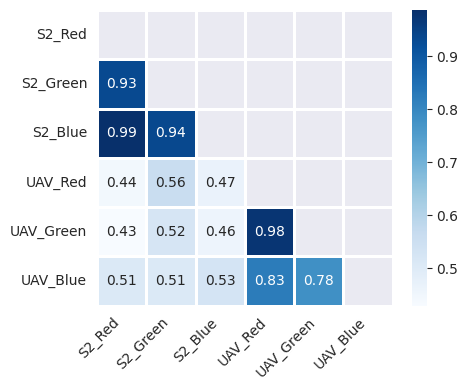

In [ ]:
# Correlation:Raw Sentinel-2 Data vs UAV Data"
df.rename(columns={'UAV_Red_Mean': 'UAV_Red',
                   'UAV_Green_Mean': 'UAV_Green',
                   'UAV_Blue_Mean': 'UAV_Blue',
                   },
           inplace=True)
cols_S2 = ["S2_Red", "S2_Green", "S2_Blue"]
cols_uav_mean = ["UAV_Red", "UAV_Green", "UAV_Blue"]


corr_struct = df[cols_S2 + cols_uav_mean].corr()

plt.figure(figsize=(5, 4))
plt.grid(False)
ax = sns.heatmap(corr_struct, annot=True, fmt=".2f", square=True,
            mask=np.triu(np.ones_like(corr_struct)),
            cmap="Blues",linewidths=1.0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # Ensure y-axis labels are horizontal
plt.tight_layout()
plt.savefig('Raw-HeatMap.png', dpi=300)
plt.show()

**Summary**
Sentinel-2 bands show moderate
*  Sentinel-2 bands highly correlated with each other (0.94-0.99)
* UAV bands highly correlated with each other (0.78-0.98) but slightly lower that the S2 bands_
*  correlation with UAV mean RGB values: r ≈ 0.43–0.63 across most S2–UAV band pairs. This suggests that broad colour gradients in the canopy are retained across spatial scales, but fine radiometric differences observed in UAV imagery are substantially smoothed at Sentinel-2 resolution.

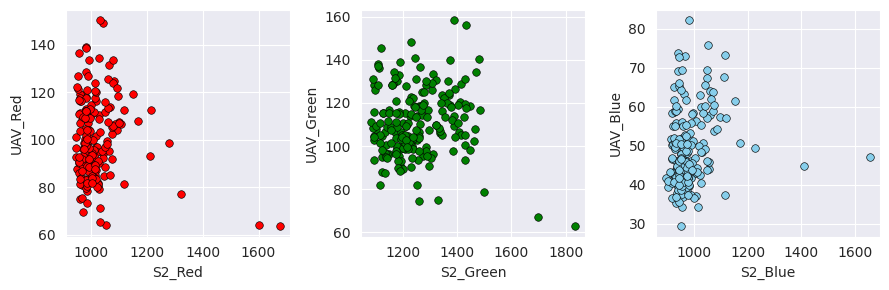

In [ ]:
#=====================================================
# Plot: Raw Sentinel-2 vs UAV Bands
#=====================================================
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=False, sharey=False)

band_pairs = [
    ("S2_Red",   "UAV_Red",   "Red"),
    ("S2_Green", "UAV_Green", "Green"),
    ("S2_Blue",  "UAV_Blue",  "Blue")
]
labels =  ['(a)', '(b)', '(c)']
cs = ['red', 'green', 'skyblue']

for ax, (s2_col, uav_col, title), c, l in zip(axes, band_pairs, cs, labels):

    # Filter non-zero values for both S2 and UAV columns
    df_nonzero = df[(df[s2_col] != 0) & (df[uav_col] != 0)]

    sns.scatterplot(
        x=df_nonzero[s2_col],
        y=df_nonzero[uav_col],
        ax=ax, s=30, color=c, edgecolor="black"
    )

    ax.set_xlabel(s2_col)
    ax.set_ylabel(uav_col)

fig.tight_layout()
plt.savefig('Raw-Scatter.png', dpi=300)
plt.show()

**Summary** Cross-scale colour information is partially preserved, reflected in the moderate positive trends.

UAV data show much richer variability, driven by sub-metre canopy structure.

Sentinel-2 reflectance cannot resolve fine-scale heterogeneity, causing diffuse scatterplots and limited predictive ability.

The consistent pattern across all three channels demonstrates that the mismatch in spatial resolution—not sensor-specific calibration—is the dominant factor limiting cross-scale reflectance transfer.

# VI

In [ ]:
# Calculate VIs
# Avoid division by zero with a tiny epsilon
eps = 1e-6

df_VI = pd.DataFrame()

R_u = df["UAV_Red_Mean"]
G_u = df["UAV_Green_Mean"]
B_u = df["UAV_Blue_Mean"]

df_VI["UAV_GRVI"] = (G_u - R_u) / (G_u + R_u + eps)
df_VI["UAV_VDVI"] = (2 * G_u - R_u - B_u) / (2 * G_u + R_u + B_u + eps)
df_VI["UAV_ExG"] = 2 * G_u - (R_u + B_u)
df_VI["UAV_GCC"] = G_u / (R_u + G_u + B_u + eps)
df_VI["UAV_GLI"] = ((G_u - R_u) + (G_u - B_u)) / ((2 * G_u) + (R_u + B_u) + eps)

R_s = df["S2_Red"]
G_s = df["S2_Green"]
B_s = df["S2_Blue"]

df_VI["S2_GRVI"] = (G_s - R_s) / (G_s + R_s + eps)
df_VI["S2_VDVI"] = (2 * G_s - R_s - B_s) / (2 * G_s + R_s + B_s + eps)
df_VI["S2_ExG"] = 2 * G_s - (R_s + B_s)
df_VI["S2_GCC"] = G_s / (R_s + G_s + B_s + eps)
df_VI["S2_GLI"] = ((G_s - R_s) + (G_s - B_s)) / ((2 * G_s) + (R_s + B_s) + eps)

KeyError: 'UAV_Red_Mean'

In [ ]:
 # Correlation: Raw Sentinel-2 vs UAV Bands
S2_cols = ["S2_GRVI", "S2_VDVI", "S2_ExG", "S2_GCC", "S2_GLI"]
UAV_cols = ["UAV_GRVI", "UAV_VDVI", "UAV_ExG", "UAV_GCC", "UAV_GLI"]
corr_pcs = df_VI[S2_cols + UAV_cols].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_pcs.loc[UAV_cols,S2_cols],
            annot=True, fmt=".3f", cmap='YlGnBu')
plt.tight_layout()
plt.savefig('VI-HeatMap.png', dpi=300)
plt.show()

**Summary**
* GCC stands out as the only index with strong cross-scale agreement (r > 0.90).

This highlights the importance of choosing indices that normalise brightness and reduce the influence of within-pixel heterogeneity when working with coarse-resolution imagery.



In [ ]:
#=====================================================
# Figure Cross-scale VI
#=====================================================

fig, axes = plt.subplots(1,3,figsize=(9, 3))

ax = axes[0]
sns.scatterplot(x=df_VI["UAV_GCC"], y=df_VI["S2_GCC"],
                ax=ax, s=30, color='navy', edgecolor="black")
#ax.set_xlim(0.33, 0.46)
#ax.set_ylim(0.35, 0.425)
ax.set_title(f"$r$ = {corr_pcs.loc["UAV_GCC", "S2_GCC"]:.2f}")
fig.tight_layout()
ax = axes[1]
sns.scatterplot(x=df_VI["UAV_ExG"], y=df_VI["S2_GCC"],
                ax=ax, s=30, color='blue', edgecolor="black")
#ax.set_xlim(10, 105)
#ax.set_ylim(0.35, 0.425)
ax.set_title(f"$r$ = {corr_pcs.loc["UAV_ExG", "S2_GCC"]:.2f}")
fig.tight_layout()

ax = axes[2]
sns.scatterplot(x=df_VI["UAV_ExG"], y=df_VI["S2_GRVI"],
                ax=ax, s=30, color='lightblue', edgecolor="black")

#ax.set_xlim(10, 105)
#ax.set_ylim(0.01, 0.2)
ax.set_title(f"$r$ = {corr_pcs.loc["UAV_ExG", "S2_GRVI"]:.2f}")
plt.savefig('VI-Scatter_CrossScale.png', dpi=300)


# PCA

In [ ]:
#=====================================================
# 0. Assumptions
#=====================================================
# - df has columns:
#   ["S2_Red","S2_Green","S2_Blue",
#    "UAV_Red_Mean","UAV_Green_Mean","UAV_Blue_Mean",
#    "UAV_Red_Std","UAV_Green_Std","UAV_Blue_Std"]
#
# - df_VI has columns:
#   ["S2_GRVI","S2_VDVI","S2_ExG","S2_GCC","S2_GLI",
#    "UAV_GRVI","UAV_VDVI","UAV_ExG","UAV_GCC","UAV_GLI"]
#
# - df and df_VI share the same index (same pixels)

#=====================================================
# 1. Select UAV metrics and run PCA
#=====================================================
uav_vars = [
    "UAV_Red_Mean", "UAV_Green_Mean", "UAV_Blue_Mean",
    "UAV_Red_Std",  "UAV_Green_Std",  "UAV_Blue_Std"
]

uav_metrics = df[uav_vars].copy()

# Standardise UAV metrics
scaler = StandardScaler()
uav_scaled = scaler.fit_transform(uav_metrics)

# PCA on UAV metrics (keep all components)
pca = PCA(n_components=len(uav_vars))
uav_pcs = pca.fit_transform(uav_scaled)

# Add PC1 and PC2 back to df
df["UAV_PC1"] = uav_pcs[:, 0]
df["UAV_PC2"] = uav_pcs[:, 1]

# Also attach PCs to df_VI (align by index)
df_VI["UAV_PC1"] = df["UAV_PC1"]
df_VI["UAV_PC2"] = df["UAV_PC2"]

expl_var = pca.explained_variance_ratio_

'''
# Print PCA summary
print("Explained variance ratio:", expl_var)

print("\nPCA components (loadings):")
for i, comp in enumerate(pca.components_, start=1):
    print(f"PC{i} loadings:")
    for var, loading in zip(uav_vars, comp):
        print(f"  {var:15s} {loading: .3f}")
    print()
'''

In [ ]:

#=====================================================
# Scree plot: PCA Scree Plot (UAV RGB Mean & Std)
#=====================================================
expl_var_pct = expl_var * 100
pcs = np.arange(1, len(uav_vars) + 1)

fig, ax = plt.subplots(figsize=(5, 2))
ax.bar(pcs, expl_var_pct, color = 'yellowgreen')
ax.plot(pcs, expl_var_pct, marker="o",c='green')
ax.set_xticks(pcs)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Var (%)")
plt.savefig('PCA-BarPlot.png', dpi=300)
#plt.text(-0.2, 0.99, '(a)', ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()

In [ ]:


#=====================================================
# PCA biplot: scores (PC1 vs PC2) + loading vectors
#=====================================================

# 1. Get scores (PC coordinates of each observation)
scores = pca.transform(uav_scaled)           # shape: (n_samples, n_components)
pc_scores = scores[:, :2]                    # first two PCs

# 2. Get loadings (as before)
loadings = pca.components_.T[:, :2]          # (variables x 2)
pc1_loadings = loadings[:, 0]
pc2_loadings = loadings[:, 1]

# 3. Scaling factors so scores fit nicely in [-1, 1] (as in Iris example)
xs = pc_scores[:, 0]
ys = pc_scores[:, 1]
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())

fig, ax = plt.subplots(figsize=(5, 4))

# Scatter of observations in PC1–PC2 space
ax.scatter(xs * scalex, ys * scaley, alpha=0.5, color = 'yellowgreen')

# Axes through the origin
ax.axhline(0, color="grey", linewidth=0.8)
ax.axvline(0, color="grey", linewidth=0.8)

# Loading vectors
for i, var in enumerate(uav_vars):
    ax.arrow(0, 0,
             pc1_loadings[i],
             pc2_loadings[i],
             color="olivedrab",
             alpha=0.6,
             head_width=0.03,
             head_length=0.03,
             length_includes_head=True)

    # Clean labels: drop "UAV_" and replace "_" with space
    label = var.replace("UAV_", "").replace("_", " ")
    ax.text(pc1_loadings[i] * 1.15,
            pc2_loadings[i] * 1.15,
            label,
            color="black",
            ha="center",
            va="center")

# Axis limits and labels
ax.set_xlim(-0.4, 0.7)
ax.set_ylim(-0.6, 0.8)
ax.set_xlabel(f"PC1 ({expl_var_pct[0]:.1f}% var)")
ax.set_ylabel(f"PC2 ({expl_var_pct[1]:.1f}% var)")
#plt.text(-0.2, 0.99, '(b)', ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()
plt.savefig('PCA-Biplot.png', dpi=300)
plt.show()

